##### Keywords: supervised learning, generative model, discriminative models, machine learning, empirical risk minimization

## Generative Versus Discriminative Models: Example
This notebook explores discriminative vs generative models via an example: Logistic Regression on one side and Linear Discriminant Analysis on the other. Even though the two models are closely related and make the same predictions, the extra assumptions in the generative model give it more capability (if the assumptions are true) and tolerance for smaller datasets. However, the discriminative model tends to do better when there is an big pile of data or the modelling assumtions are questionable.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.8):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    return clf, Xtrain, ytrain, Xtest, ytest

In [3]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

In [4]:
#from REF
from scipy import linalg

def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(mean, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5,
                              180 + angle, color=color, lw=3, fill=False)
    ell.set_clip_box(splot.bbox)
    ell1 = mpl.patches.Ellipse(mean, 1 * v[0] ** 0.5, 1 * v[1] ** 0.5,
                              180 + angle, color=color, lw=3, fill=False)
    ell1.set_clip_box(splot.bbox)
    ell3 = mpl.patches.Ellipse(mean, 3 * v[0] ** 0.5, 3 * v[1] ** 0.5,
                              180 + angle, color=color, lw=3, fill=False)
    ell3.set_clip_box(splot.bbox)
    #ell.set_alpha(0.2)
    splot.add_artist(ell)
    splot.add_artist(ell1)
    splot.add_artist(ell3)


    #splot.set_xticks(())
    #splot.set_yticks(())
def plot_lda_cov(lda, splot):
    plot_ellipse(splot, lda.means_[0], lda.covariance_, 'red')
    plot_ellipse(splot, lda.means_[1], lda.covariance_, 'blue')
#plt.bivariate_normal(X, Y, sigmax=1.0, sigmay=1.0, mux=0.0, muy=0.0, sigmaxy=0.0)¶

### Data
Our dataset is the hieght and weight measurments for several hundred men and women. We pick the binary Gender variable as our variable of interest and aim to predict it via height and weight.

In a more general setting we may be predicting a continuous variable. The distinctions we draw about generative and non-generative models will still hold as we move from classiffication problems to regression/prediction problems.

In [5]:
df=pd.read_csv("data/01_heights_weights_genders.csv")
df.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


### Discriminative Model: Logistic Regression
You've hopefully seen logistic regression a few times: it takes in the dataset and hands back a fitted model which eats new height and weight values and tells you the estimated probability of that height/weight combination belonging to a male (instead of a female)

Logistic regression is discriminative/non-generative in that it doesn't provide a model for the height/weight data. The returned model couldn't tell us that a height of 6 feet and a weight of 100 lbs is unlikely. It would just tell us whether that person is more likely male or female.

An _even more_ discriminative model would be a Support Vector Machine or k-nearest neighbors, if you are familiar with either. Given new height and  weight values, those models don't even estimate the probability of male vs female: they just give back a predicted class. Thier only goal is to disciminate between the classes, that is, to draw boundaries where one class gives way to another.

In [6]:
from sklearn.linear_model import LogisticRegression
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), {"C": [0.01, 0.1, 1, 10, 100]}, df, ['Weight', 'Height'], 'Gender','Male')

BEST PARAMS {'C': 0.01}
Accuracy on training data: 0.92
Accuracy on test data:     0.92


Now that we've fit the model, let's see what the boundary looks like (along with the raw data):

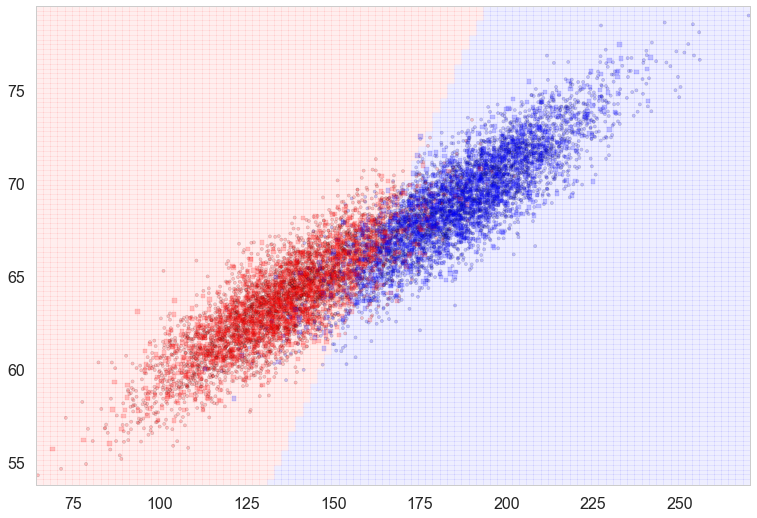

In [7]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain_l, Xtest_l, ytrain_l, ytest_l, clf_l, alpha=0.2);

Let us plot the probabilities obtained from `predict_proba`, and the predicted labels

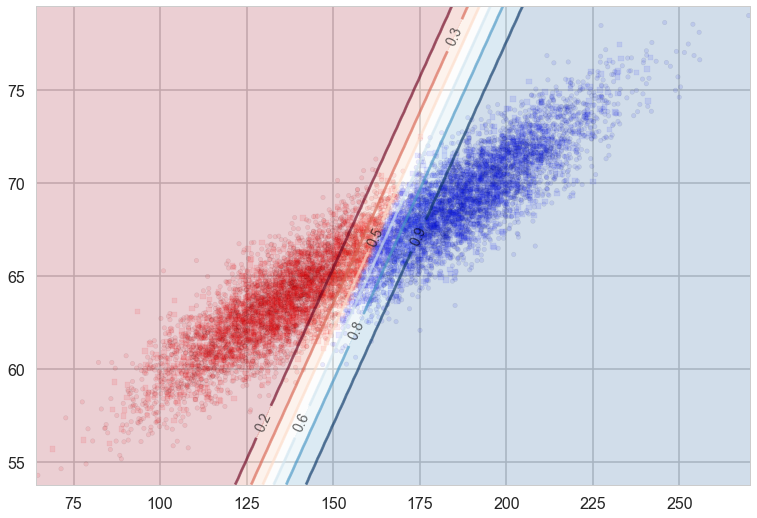

In [8]:
plt.figure()
ax=plt.gca()
points_plot_prob(ax, Xtrain_l, Xtest_l, ytrain_l, ytest_l, clf_l, psize=20, alpha=0.1);

Notice that lines of equal probability are stright lines becuase height and weight entered the regression as linear terms (i.e. there were no interaction or higher-order terms). 

What the classifier does is very intuitive: if the probability (of maleness) is estimated to be greater than 0.5, it classifies the sample as type '1' (male), otherwise it classifies the sample to be class '0' (female). Thus there is a clear demarcation between predicted classes at the 0.5 probability line.

In other words we are asking, given $\v{x}$, what is the probability of a given $y$ or, what is the likelihood $P(y|\v{x},\v{w})$?

An even more brutal / less assumption-heavy approach like SVMs would endavour to JUST draw the line between the classes and skip trying to draw the extra equal-probability lines in the diagram above.

### Generative Classifier: LDA
LDA, for those unfamiliar, assumes that once class lables are known, the X data for each class are distributed normally- the goal is to find the center and spread the normal distribution encompassing each class. Classification for a given set of x data comes via guessing it belongs to the class most likely to produce that x, i.e. the class whose normal distribution is highest at the point x.

Let's run it, only on the training set. What we are doing is fitting the male and female sections of the training set separately, getting two 2-D bell curves, and then inverting as above to decide how to classify new samples from the testing set. (We dont cross-validate here as we are currently not fitting any hyperparameters).

In [13]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
clflda = LDA(solver="svd", store_covariance=True)
clflda = clflda.fit(Xtrain_l, ytrain_l)

We plot ellipses for equal probability contours of the two individual $P(\v{x}|y)$, the $P(height, weight | male)$ and the $P(height, weight | female)$. We also plot the discriminant line created by inverting these probabilities using Bayes theorem: we once again classify a sample as male if $P(male | height, weight) \gt 0.5$ (which will ensure that $P(female | height, weight) < 0.5$ since both must add to 1).

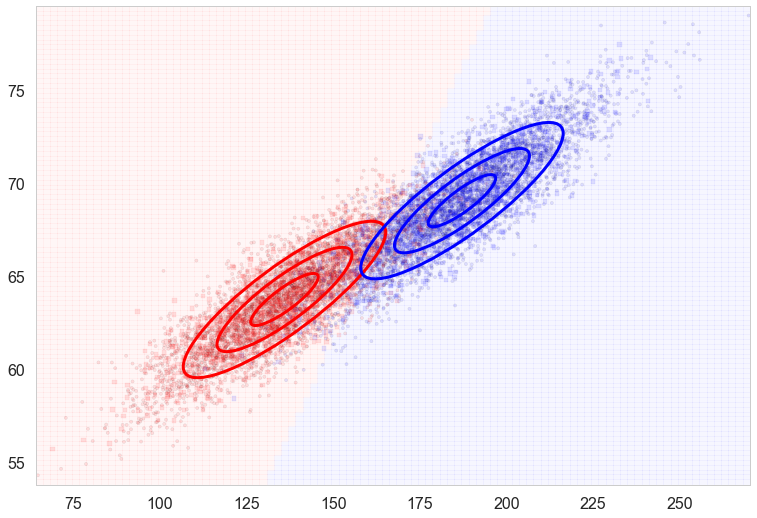

In [10]:
plt.figure()
ax=plt.gca()
spl,_,_=points_plot(ax,Xtrain_l, Xtest_l, ytrain_l, ytest_l, clflda)
plot_lda_cov(clflda, spl)


Whats happenning here? We have estimated $P(\v{x} | y, \theta_y)$ where we use $\theta_y$ to designate the parameters of the fit (the parameters of the female and male bell curves); the subscript indicates we are fitting a separate parameter set for each class.

We can then use Bayes theorem to invert to find $P(y | \v{x})$, the probability we really want thus:

$$P(y | \v{x}) = \frac{P(\v{x} | y, \theta_{y}) P(y)}{P(x)} = \frac{P(\v{x} | y) P(y)}{\sum_{y} P(\v{x} | y, \theta_{y})P(y)} .$$

Notice from the first term above that the denominator $P(\v{x})$ does not involve the parameters, it is simply the input distribution of the features. As such, it is not needed in the prediction process.

For our special case of two classes:

$$P(y = c_1 | \v{x}) = \frac{P(\v{x} | y = c_1, \theta_1) P(y=c_1)}{P(\v{x} | y = c_1, \theta_1) P(y=c_1) + P(\v{x} | y = c_0, \theta_0) P(y=c_0)}$$

In other words, we first look at males, and build a model of the features for the males. Then we do a similar thing for females. To classify a new sample, we match it against the model for males, and then the model for females, and use Bayes' theorem to see if the new sample more likely looks like the males rather than the females from the training set.


#### What makes it generative
A nice feature of the LDA model is that you can **generate** or simulate a new male or female sample from this model $P(\v{x} | y, \theta_y)$ of males or females respectively. The idea is that you first toss a (possibly biased) coin which depends on $P(y=c_1)$, the "prior" probability of a sample being male or female. Once that coin has landed male or female ("once the draw has been made"), generate a sample in feature space using $P(\v{x}|what landed)$. For example, if the coin landed female, now draw a height and weight according to 

$$P(height, wieght | female )$$ 

Thus there is a *story* for how to generate samples in such models. First nature decides A, then knowing A it sets B, and so on. If this story is the "correct" or "nearly correct" one, this is likely to be a very good model, and furthermore, we can draw new training sets to check variance and other measures of our classifier's accuracy.

In a regression (instead of classification) context, e.g. where we predict age via height and weight, the generative process would be "draw age from [whatever distribution seems to hold for the population]. Given age, draw height and weight from the height/weight distribution for that age.

#### Tunable Priors
The formula involves $P(y)$, the prior probability of a sample being in class y. This term is usually just taken to be the fraction of a particular class in the training sample.

Including the prior probability of class=y is key when the classes are very imbalanced in the training data set. For example, consider again the case of trying to predict if a customer will "churn". Typically churn rates are low, of the order of 2-3%. In this case having the prior probabilities of churning and not-churning and modelling these groups separately in a generative classifier is very useful: it might be hard for a discriminative classifier to draw a boundary between many many samples on one side and just a few on the other. 

Equivalently, there are few samples from the "churn" class, so backing the data up with distributional assumptions can compensate for not having enough data to emperically learn its distribution.

#### Drawbacks?
We are being asked to provide much more information than in the logistic regression case: the priors, the individual class models, all of that. There are a lot of assumptions, but it is not a bad thing when the assumptions that go into individual models are well founded, such as in the case of our male and female heights and weights here- the heights and weights prettymuch _are_ normaly distributed, and we get a more powerful model back.

### Comparing

We can also plot the output of `predict_proba` for the LDA, like we did with logistic regression. We see something interesting: we get back exactly the same probability lines that we got using logistic regression. Indeed, LDA is the generative conterpart of Logistic regression. It is possible to prove this but we shall not do so here.

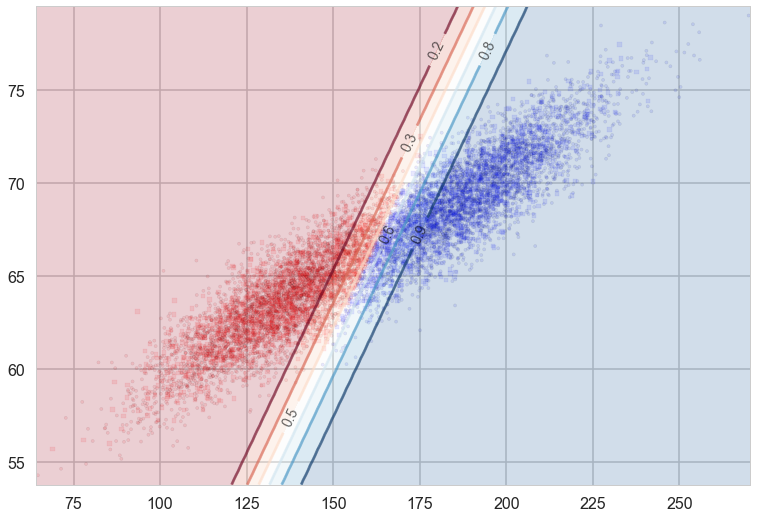

In [11]:
plt.figure()
ax=plt.gca()
points_plot_prob(ax, Xtrain_l, Xtest_l, ytrain_l, ytest_l, clflda);

An important point here is that _many_ generative models have Logistic Regression as their discriminative counterpart, including those with Poisson Likelihoods and Naive Bayes Models. This means that on inverting the $P(\v{x}|y)$ using Bayes theorem, we get back Logistic Regression. Thus Logistic regression is a relatively robust model, insensitive to many modelling assumptions. This is a big reason to use such Discriminative models.

But if $p(\v{x}|y)$ is indeed Normal, as is here for our two classes of male and female, LDA is what is known as **asymptotically efficient**. This means that for large amounts of training data, it can be proved that no model can be better than LDA for the estimation of $p(y|\v{x})$, the probability we care about. In particular, it can be shown that LDA will outperform Logistic regression, even for small training set sizes.

Finally note that there is another major advantage of a generative classifier. We can sum up over class conditional probably density weighted by the priors to estimate the input density from the probability marginalization formula. $P(x) = \sum_y P(x|y)P(y)$ That is, we can find the probability of seeing a particular set of X data and do tasks like outlier detection.

That LDA would be more powerful is not surprising. A lot of elbow-grease went into the generative classifier since we had to model so much. It should pay some dividend.

### Generative vs Discriminative, summarized

This is perhaps the right time then to revisit the generative vs discriminative argument, now that we have some experience under our belt.

- If we only wish to make classification decisions rather than more complex decisions then discriminative might be all we need, and it is cheaper in terms of computing resources. But asymmetry and the ability to generate synthetic data are strengths of the generative approach.
- sometimes generative models like LDA and Naive Bayes are easy to fit. The discriminative model LogisticRegression requires convex optimization via Gradient descent
- we can add new classes to a generative classifier without retraining for the previous classes so it might be better for online customer selection problems where customer profiles change
- generative classifiers can handle missing data easily
- generative classifiers are better at handling unlabelled training data (semi-supervized learning)
- preprocessing data is easier with discriminative classifiers
- discriminative classifiers give generally better callibrated probabilities